<a href="https://colab.research.google.com/github/whitcrrd/puzzle-image-segmentation/blob/master/Puzzler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Reed Whitcraft
# June/July 2019

# Capstone Project: Image Segmentation & Feature Matching

### Project Purpose/Function (TLDR):

Given an image of a puzzle piece and an image of its box, predict where the piece belongs in the puzzle.

## Project Purpose/Function:

### Part I: Image Segmentation (Puzzle Piece) - Identifying Object Outlines

Using a regional convolutional neural network, Mask R-CNN, pretrained on the COCO dataset, train a model to detect, classify, and segment a custom object (puzzle piece).  By using weights from a model previously trained on the COCO dataset, we can start off with a network that has already learned a lot of the more common features (ex. edges).  Freezing the base layers, and training the final layers of the R-CNN with custom data (annotated images of puzzle pieces), we can hopefully end up with a model that can detect individual puzzle pieces.

The Mask R-CNN can be broken down into two stages:

1. Image is scanned and a proposal is generated (region of interest where object may be present)

2. Classification of proposals and bounding box/mask generation.


### Training/Validation Data

In order to train a model to make (accurate) predictions, we need a training (and validation, ideally) dataset.  For image segmentation, that means we need to provide images of the focus/subject (puzzle piece) with its outlines traced as clearly as possible.  There are a handful of annotation programs designed for image segementation, and the (free) [VGG Image Annotator (VIA)](http://www.robots.ox.ac.uk/~vgg/software/via/) works well and was used for the creation of the datasets.  For this project, photos were taken of individual puzzle pieces on white backgrounds, in the box, on the box, and in one's hand.  In most situations, the more data the better (thousands or millions), but because we are taking advantage of transfer learning, it is not necessary to have as much data.  However, it is important to have the training and validation data accurately annotated and in situations/backgrounds that we expect in the wild.

The following is a timelapse of an annotation created in VIA.  VIA exports these annotations as JSON, with the (x, y) coordinates outlined in the image, as well as a reference to the image filename and the assigned class (piece) contained in the polygons.

![annotation-gif](https://i.imgur.com/En6Yp8M.gif)

### Part Ia: Extraction of Image Segmentation

Once the model is trained (well enough) to detect, classify and localize a puzzle piece, we need to extract just that puzzle piece.  Given that the Mask R-CNN detection provides us with a mask that covers the predicted pixels of the subject, we can create a new image of only these pixels of the original photo.  

### Part II: Feature Matching - Finding Patterns In One Image In Another

After training a model to detect puzzle pieces and obtaining the isolated piece, we want to see if we can match the features in the piece to a picture of the box, which would contain the piece.  To achieve this, we'll use the SIFT (Scale Invarient Feature Transform) algorithm to help detect matches between the puzzzle piece and the box, with the goal of being able to predict the location and orientation of the original puzzle piece in the puzzle.  


### Intended End Result

![feature matches](https://i.imgur.com/Ge0k4gX.gif)




# Part I: Project Setup


To get started, ***create a root project directory*** anywhere you'd like in google drive.  Then, ***unzip the dataset*** ([DATASET](https://drive.google.com/open?id=1cCzpSrCailM01F9PgaP7UMoMFw5J7tHZ)) and rename the folder to 'dataset' if needed, which should live in the root project directory you've chosen.

*   Import Libraries (OpenCV, pandas, numpy, matplotlib, etc.)
*   Connect Google Drive (where the dataset, model checkpoints, etc will live)
*   Clone Mask R-CNN repo & COCO API and install requirements
*   Create/Update Project Directory Structure





### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Install OpenCV (SIFT removed in later versions, so reverting to an older version)

In [2]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 25.0MB 9.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.5.20
    Uninstalling opencv-python-3.4.5.20:
      Successfully uninstalled opencv-python-3.4.5.20
     |████████████████████████████████| 30.6MB 1.4MB/s 
  Found existing installation: opencv-contrib-python 3.4.3.18
    Uninstalling opencv-contrib-python-3.4.3.18:
      Successfully uninstalled opencv-contrib-python-3.4.3.18


In [3]:
# check version to make sure we have the one with SIFT
import cv2
cv2.__version__

'3.4.2'

### Install Preliminary Libraries

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from ipywidgets import interact, interactive
import warnings
import skimage.draw
import sys
import json

In [0]:
def print_current_directory():
  current_directory = os.getcwd()
  print("*_*_* CURRENT DIRECTORY *_*_*")
  print(current_directory)
  return current_directory

In [6]:
current_directory = print_current_directory()

*_*_* CURRENT DIRECTORY *_*_*
/content


### Set Project, Mask RCNN, and COCO Paths

If running this yourself, be sure to change the root project directory to wherever in google drive you'll be saving your images, results, and importing.

In [0]:
ROOT_PROJECT_DIR = Path('/content/gdrive/My Drive/2019_06_Puzzle')
MASK_RCNN_DIR = ROOT_PROJECT_DIR / 'Mask_RCNN'
COCO_DIR = MASK_RCNN_DIR / 'coco'

Additionally, in the root project directory, if you will want to create a `results` folder, which will hold the IoU results, keras model history, clipped pieces, and feature matches, and a `training_logs` folder, which will hold the model checkpoints after each epoch during training.  We'll do this below

In [17]:
if not os.path.isdir(ROOT_PROJECT_DIR / "results"):
  os.mkdir(ROOT_PROJECT_DIR / "results")
  os.mkdir(ROOT_PROJECT_DIR / "results/clipped_pieces")
  os.mkdir(ROOT_PROJECT_DIR / "results/feature_matches")
else:
  print("results folders already created")

results folders already created


And a directory for holding the training logs

In [18]:
if not os.path.isdir(ROOT_PROJECT_DIR / "training_logs"):
  os.mkdir(ROOT_PROJECT_DIR / "training_logs")
else:
  print("training logs folder already created")

training logs folder already created


In [8]:
# change directory into project folder ('2019_06_Puzzle')
if current_directory == '/content':
  os.chdir(ROOT_PROJECT_DIR)
  print_current_directory()

os.listdir()

*_*_* CURRENT DIRECTORY *_*_*
/content/gdrive/My Drive/2019_06_Puzzle


['images',
 'images.zip',
 'training_logs',
 'piece_detector_config.py',
 'Mask_RCNN',
 'mask_rcnn_coco.h5',
 'splash_20190702T234006.png',
 'splash_20190702T234439.png',
 'splash_20190702T234557.png',
 'splash_20190703T003406.png',
 'splash_20190703T024735.png',
 'splash_20190703T210149.png',
 'splash_20190703T210613.png',
 'splash_20190703T220509.png',
 'splash_20190707T215219.png',
 'splash_20190707T234734.png',
 'results',
 'coco']

### Clone Mask R-CNN & COCO API & Install Requirements

#### Clone Mask_RCNN

In [9]:
# clone Mask_RCNN if not already cloned.
if os.path.isdir(MASK_RCNN_DIR):
  print("destination path already exists and is not empty")
else: 
  !git clone --quiet https://github.com/matterport/Mask_RCNN.git

destination path already exists and is not empty


#### Install Mask_RCNN Requirements

In [10]:
os.chdir('Mask_RCNN')
!pip install -q PyDrive
!pip install -r requirements.txt
!python setup.py install

     |████████████████████████████████| 993kB 9.4MB/s 
     |████████████████████████████████| 204kB 9.6MB/s 
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py 

#### Clone COCO

In [11]:
# clone coco repo if not already cloned.
if os.path.isdir(COCO_DIR):
  print("destination path coco already exists and is not empty")
else:
  !git clone https://github.com/waleedka/coco

destination path coco already exists and is not empty


#### Install COCO Requirements

In [12]:
os.chdir('coco/PythonAPI')
!python setup.py install
os.chdir('../..')
!python setup.py install

running install
running build
running build_py
running build_ext
running install_lib
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> /usr/local/lib/python3.6/dist-packages/pycocotools
running install_egg_info
Writing /usr/local/lib/python3.6/dist-packages/pycocotools-2.0.egg-info
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.

### Dataset Details

The dataset was self-created by taking photos of puzzle boxes and their respective pieces (using iPhone X), and the training and validation datasets were annotated using the VIA online editor.

***Training Set***: 95 images with annotations

***Validation Set***: 22 images with annotations

***Test Set***: 20+ images from 4 different puzzles

### Create Dataset Folder & Move Training/Validation Images

For the Mask RCNN and this project, I'll be keeping the training, validation, and test images in separate folderss inside the root project repo.  The training and validation directories will also have a JSON annotation file, which has the polygon points for each puzzle piece in an image, as well as references to its associated image filename.

If running through this notebook. Be sure to create the following directories, and copy your images and annotation files into their respective destinations.

**Training Images Location**: 
-   ROOT_PROJECT_DIRECTORY/dataset/images/training (images & 1 annotation file)

**Validation Images Location**:
-  ROOT_PROJECT_DIRECTORY/dataset/images/val (images & 1 annotation file)

**Test Images Location**:
-   ROOT_PROJECT_DIRECTORY/dataset/images/test


The test images have a slightly different directory structure than the training and validation images.  Inside the test folder, there is a folder for each box (`box_1`, `box_2`, etc.) and inside each box folder is the box image (`box.jpeg`) and another folder, `pieces` which contain images of the pieces belong to that box.

#### Set Path to Pretrained COCO Weights File

In [0]:
COCO_WEIGHTS_PATH = Path(ROOT_PROJECT_DIR) / "mask_rcnn_coco.h5"

#### Download Pre-Trained COCO Weights (If Not Done Previously)

In [0]:
if not COCO_WEIGHTS_PATH.exists():
  utils.download_trained_weights(
      str(COCO_WEIGHTS_PATH)  
  )

# Part II: Mask R-CNN Customization & Model Training

*  Setting/Creating Directory Paths for training logs, database images, model weights
*  Config class:  inheriting from Mask R-CNN and overwriting custom class, number of classes, epochs
*  Dataset class:   inheriting from Mask R-CNN, and defining how to load/read/process images and their annotations
*  Train model
*  Accuracy Metrics Review

### Set Paths for Logs (Model Checkpoints), Dataset, Weights

In [0]:
# where to save logs and model checkpoints
DEFAULT_LOGS_DIR = ROOT_PROJECT_DIR / "training_logs"

# where training images and annotations files live
DATASET_PATH = ROOT_PROJECT_DIR / "dataset/images"

# start training from pre-trained COCO model
WEIGHTS_TO_START_FROM = COCO_WEIGHTS_PATH

SAVED_MODEL_WEIGHTS_PATH = None

## Customize Mask R-CNN

To use Mask R-CNN on the puzzle piece images, I'll have to overwrite some of the base class functions/configuration files.

Namely:

1. ***PieceDetectorConfig*** (inheriting from Config) - applying name to custom object ('piece'), number of classes, steps per epoch, adjustment of model weights, etc.

2. ***ViaDataset*** (inheriting from utils.Dataset) - telling Mask R-CNN what type of annotations we have (JSON) and how to associate them with their respective image files

In [16]:
# import config, model, and utils from cloned mask_rcnn repo
from mrcnn.config import Config
from mrcnn import model as modellib, utils

Using TensorFlow backend.


### Overwrite Mask_RCNN Base Classes (Object Detector, Dataset (& Annotations))

In [0]:
class PieceDetectorConfig(Config):
  NAME = "piece" # custom object name
  IMAGES_PER_GPU = 1
  NUM_CLASSES = 1 + 1 # background + piece
  STEPS_PER_EPOCH = 100
  DETECTION_MIN_CONFIDENCE = 0.9
  MINI_MASK_SHAPE = (224,224) # DEFAULT = (56,56)
  LOSS_WEIGHTS = {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
  DETECTION_MAX_INSTANCES = 1 # DEFAULT = 100
  MAX_GT_INSTANCES = 1 # DEFAULT = 100
  
  

### Dataset Class (Dataset Paths, and Handling JSON Annotations)

The Mask R-CNN requires us to subclass a `Dataset` class and reimplement methods for the reading and parsing annotations and generation of masks.  Annotations can come in XML or JSON format, but the VGG Image Annotator exports in JSON, so this class will customize the dataset to expect JSON.

In [0]:
class VIADataset(utils.Dataset):
  
  def load_training_images(self, dataset_dir, subset):
    """
    dataset_dir: root directory of dataset
    subset: subset to load (train / val)
    """
    dataset_dir = dataset_dir / subset
    
    # annotations saved in {folder} (train/val) with filename => "via_region_data.json"
    annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
    annotations = list(annotations.values())
    
    # add class, only one class to add
    self.add_class("piece", 1, "piece")
    
    # Add images
    for a in annotations:
        # Get the x, y coordinaets of points of the polygons that make up
        # the outline of each object instance. There are stores in the
        # shape_attributes (see json format above)
        if type(a['regions']) is dict:
          polygons = [r['shape_attributes'] for r in a['regions'].values()]
        else:
          polygons = [r['shape_attributes'] for r in a['regions']]

        # load_mask() needs the image size to convert polygons to masks.
        # Unfortunately, VIA doesn't include it in JSON, so we must read
        # the image. 
        image_path = os.path.join(dataset_dir, a['filename'])
        image = skimage.io.imread(image_path)
        height, width = image.shape[:2]
        
        # add the image to the dataset
        self.add_image(
            source="piece",
            image_id=a['filename'],
            path=image_path,
            width=width, height=height,
            polygons=polygons
        )
  
  def load_mask(self, image_id):
    # Convert polygons to a bitmap mask of shape
    # [height, width, instance_count]
    info = self.image_info[image_id]
    mask = np.zeros([info["height"], 
                    info["width"], 
                    len(info["polygons"])],
                    dtype=np.uint8)
    
    for i, p in enumerate(info["polygons"]):
       #Get indexes of pixels inside the polygon and set them to 1
        rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        mask[rr, cc, i] = 1
    # Return mask, and array of class IDs of each instance. Since we have
    # one class ID only, we return an array of 1s
    return mask, np.ones([mask.shape[-1]], dtype=np.int32)
  
  def image_reference(self, image_id):
    # get path for image
    info = self.image_info[image_id]
    return info["path"]

## Train Model

### Wrapping Model Configuration

In [0]:
def train(model):
  '''
  wrapper method that instantiates the custom database (above) for training and validation,
  loads the images
  calls model.train(), passing in training dataset, val dataset, learning rate, epochs, and which layers to train on
  '''
  dataset_train = VIADataset()
  dataset_train.load_training_images(
      DATASET_PATH,
      "train"
  )
  dataset_train.prepare()
  
  dataset_val = VIADataset()
  dataset_val.load_training_images(
      DATASET_PATH,
      "val"
  )
  dataset_val.prepare()
  
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    
    model.train(
        dataset_train,
        dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=10,
        layers='heads'
    )
  

### Initialize Model & Load Weights

In [21]:
config = PieceDetectorConfig() # the custom config we just wrote
config.display()

model = modellib.MaskRCNN(
    mode='training',
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    str(WEIGHTS_TO_START_FROM),
    by_name=True,
    exclude=[
        "mrcnn_class_logits",
        "mrcnn_bbox_fc",
        "mrcnn_bbox",
        "mrcnn_mask"
    ]
)

W0721 23:20:36.188082 139695697848192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 23:20:36.234782 139695697848192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 23:20:36.263044 139695697848192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 23:20:36.301086 139695697848192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0721 23:20:36.306552 139695697


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

W0721 23:20:39.045651 139695697848192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0721 23:20:39.613417 139695697848192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0721 23:20:39.748946 139695697848192 deprecation_wrapper.py:119] From /content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/mrcnn/model.py:553: The name tf.random_shuffle is deprecated. Please use tf.random.shuffle instead.

W0721 23:20:39.948824 139695697848192 deprecation_wrapper.py:119] From /content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/mrcnn/utils.py:

### Train Mode (Actually)


Train model on the COCO database.

In [0]:
# run training process 
train(model)


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/My Drive/2019_06_Puzzle/training_logs/piece20190716T1504/mask_rcnn_piece_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (Ti

#### Save Model History Metrics (Only After Training)

In [0]:
# model_history 20 epochs, new training and validation data
model_history_20 = model.keras_model.history.history

model_history_df_20 = pd.DataFrame.from_dict(model_history_20)
model_history_df_20

#### Save/Load Model History Metrics (If Previously Trained)

In [22]:
# where to save the accuracy/loss metrics
MODEL_HISTORY_DIR = ROOT_PROJECT_DIR / "results/model_history_20_final.csv"

# if we've already ran the model and saved its history
if os.path.isfile(MODEL_HISTORY_DIR) == True:
  model_history_df_20 = pd.read_csv(MODEL_HISTORY_DIR)
else:
  model_history_df_20.to_csv(MODEL_HISTORY_DIR, index=False)

model_history_df_20

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
0,0.790471,0.003280,0.206716,0.029944,0.360790,0.189739,1.339771,0.003033,0.277824,0.041485,0.619326,0.398102
1,0.513271,0.004185,0.142634,0.017083,0.182377,0.166990,0.731710,0.003543,0.187907,0.026491,0.294297,0.219471
2,0.480642,0.002537,0.163691,0.009903,0.162370,0.142141,0.523093,0.005272,0.114810,0.019475,0.189689,0.193846
3,0.460870,0.001552,0.157399,0.013548,0.132565,0.155804,0.440923,0.002745,0.136113,0.011409,0.131371,0.159284
4,0.395529,0.003050,0.122023,0.011092,0.116827,0.142536,0.362064,0.001931,0.093550,0.011355,0.104094,0.151133
5,0.390255,0.001005,0.136503,0.010688,0.106399,0.135658,0.325996,0.002096,0.090798,0.010438,0.078789,0.143873
6,0.376746,0.003146,0.138318,0.009641,0.079561,0.146079,0.323785,0.001931,0.098217,0.011472,0.076433,0.135731
7,0.388402,0.001532,0.155149,0.011449,0.073677,0.146594,0.256095,0.001594,0.067801,0.009339,0.059067,0.118293
8,0.362865,0.003222,0.140201,0.007005,0.075870,0.136566,0.251225,0.002207,0.069672,0.008668,0.054098,0.116579
9,0.354096,0.003279,0.127383,0.004893,0.081492,0.137048,0.232308,0.001284,0.067928,0.005998,0.044842,0.112253


### Visualize Loss Metrics

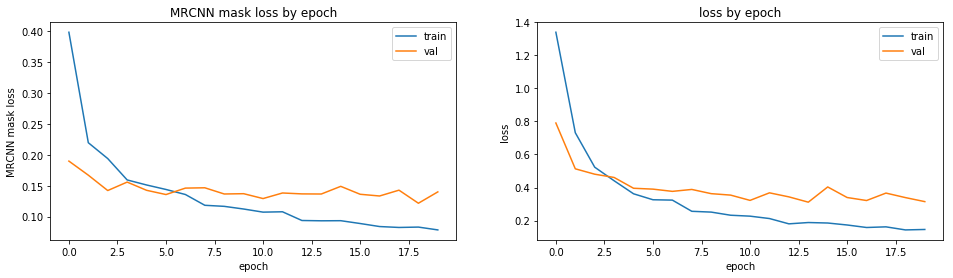

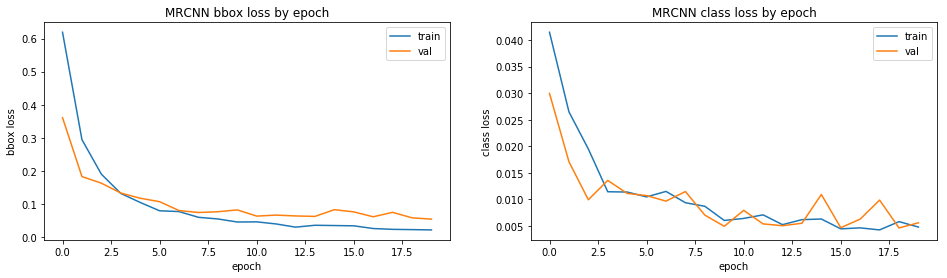

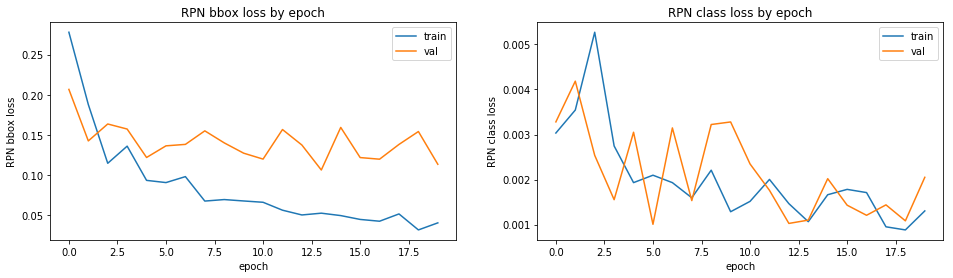

In [23]:
model_history_df = model_history_df_20

## ROW ONE: MRCNN MASK LOSS, VAL LOSS
f = plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(model_history_df['mrcnn_mask_loss'])
plt.plot(model_history_df['val_mrcnn_mask_loss'])
plt.title('MRCNN mask loss by epoch')
plt.ylabel('MRCNN mask loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(model_history_df['loss'])
plt.plot(model_history_df['val_loss'])
plt.title('loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

## ROW TWO
f = plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(model_history_df['mrcnn_bbox_loss'])
plt.plot(model_history_df['val_mrcnn_bbox_loss'])
plt.title('MRCNN bbox loss by epoch')
plt.ylabel('bbox loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(model_history_df['mrcnn_class_loss'])
plt.plot(model_history_df['val_mrcnn_class_loss'])
plt.title('MRCNN class loss by epoch')
plt.ylabel('class loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

## ROW THREE
f = plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(model_history_df['rpn_bbox_loss'])
plt.plot(model_history_df['val_rpn_bbox_loss'])
plt.title('RPN bbox loss by epoch')
plt.ylabel('RPN bbox loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(model_history_df['rpn_class_loss'])
plt.plot(model_history_df['val_rpn_class_loss'])
plt.title('RPN class loss by epoch')
plt.ylabel('RPN class loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

# Part III: Model Validation (Inference Mode - Validation Images)

### Import Libraries

Note, some of these have already been imported, but if skipping through the training, we'll need these.

In [0]:
import mrcnn.config
import mrcnn.visualize
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path

### Config Class for Inference

In [0]:
# customize config for inference mode
class PieceDetectorConfig(mrcnn.config.Config):
  NAME = "piece" # custom object name
  IMAGES_PER_GPU = 1
  GPU_COUNT = 1
  NUM_CLASSES = 1 + 1 # custom object + background
  DETECTION_MAX_INSTANCES = 1 # looking for only one piece per validation image

### Set Weights From Model Checkpoint

In [0]:
MODEL_DIR = ROOT_PROJECT_DIR / "training_logs"
TRAINED_MODEL_PATH = DEFAULT_LOGS_DIR / "piece20190716T1504" / "mask_rcnn_piece_0020.h5" # new config values

### Instantiate Model (Inference Mode)

In [27]:
# create mask-rcnn model in inference mode
model_inference = MaskRCNN(
    mode='inference',
    model_dir=MODEL_DIR,
    config=PieceDetectorConfig()
)

model_inference.load_weights(
    str(TRAINED_MODEL_PATH),
    by_name=True
)

W0721 23:22:27.886961 139695697848192 deprecation_wrapper.py:119] From /content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/mrcnn/model.py:720: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0721 23:22:27.993700 139695697848192 deprecation.py:323] From /content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/mrcnn/model.py:772: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Re-starting from epoch 20


## Inspect Performance on Validation Set

#### Initialize Dataset

In [0]:
class_names = ['BG', 'piece'] # single class, but background counts as second

# create dataset_val to access validation images (which are re-shaped)
dataset_val = VIADataset()
dataset_val.load_training_images(
      DATASET_PATH,
      "val"
)
dataset_val.prepare()

piece_detector_config = PieceDetectorConfig()

In [29]:
val_images_index = list(range(22))
val_images_index

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

#### Display Differences Method

When displaying differences, we will be taking the ground truth mask/background (from the annotations), and predicted mask/background and displaying them both on top of the original image.  This allows us to visualize how accurate the masks are, and is sometimes, a better indicator of progress/success than numbers/averages without visualizations.

In [0]:
def display_differences(dataset=dataset_val, config=piece_detector_config, image_index=0):
  """Display ground truth bounding box and mask (green) and predicted bounding box and mask (red), with score/IoU
  
  dataset: custom dataset from above, to access training images by ID (index) because they are resized
  config: custom config for inference
  image_index: index of IMG in custom dataset
  
  """
  
  # get ground truth values
  gt_image, gt_shape, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_index)
  
  # run model inference on image
  results = model_inference.detect([gt_image], verbose=1)
  r = results[0]
  
  # set predicted values from model inference results
  pred_box, pred_class_id, pred_score, pred_mask = r['rois'], r['class_ids'], r['scores'], r['masks']
  
  fig, ax = plt.subplots(figsize=(6,6))
  
  # display differences between ground truth and prediction
  mrcnn.visualize.display_differences(
    gt_image, gt_bbox, gt_class_id, gt_mask,
    pred_box, pred_class_id, pred_score, pred_mask,
    class_names, ax=ax
  )
  
  # compute IoU for masks
  overlaps = mrcnn.utils.compute_overlaps_masks(gt_mask, pred_mask)[0][0]
  
  # compute IoU for boxes
  overlaps_box = mrcnn.utils.compute_overlaps(gt_bbox, pred_box)[0][0]
  
  print(" IoU (Mask): {}".format(overlaps))
  print(" IoU (Box): {}".format(overlaps_box))
  
  # return IoU values
  return {'iou_mask': overlaps, 'iou_box': overlaps_box}
 

#### Compute Intersection Over Union

Intersection over Union, covered later, provides us with the numbers associated with the visualized differences between predicted and ground truth masks/bounding boxes.  

In [0]:
def compute_ious(dataset=dataset_val, config=piece_detector_config, image_index=0):
  """Calculate only IoU (no visualizations) for given image index, returning {'iou_mask': , 'iou_box':}
  
  dataset: custom dataset from above, to access training images by ID (index) because they are resized
  config: custom config for inference
  image_index: index of IMG in custom dataset
  """
  
  # get ground truth values
  gt_image, gt_shape, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_index)
  
  # run model inference on image
  results = model_inference.detect([gt_image], verbose=1)
  r = results[0]
  
  # set predicted values from model inference results
  pred_box, pred_class_id, pred_score, pred_mask = r['rois'], r['class_ids'], r['scores'], r['masks']
  
  # compute IoU for masks
  overlaps = mrcnn.utils.compute_overlaps_masks(gt_mask, pred_mask)[0][0]
  
  # compute IoU for boxes
  overlaps_box = mrcnn.utils.compute_overlaps(gt_bbox, pred_box)[0][0]
  
  print(" IoU (Mask): {}".format(overlaps))
  print(" IoU (Box): {}".format(overlaps_box))
  
  # return IoU values
  return {'iou_mask': overlaps, 'iou_box': overlaps_box}
  

#### Apply `display_differences` on Single Validation Image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
 IoU (Mask): 0.8673806190490723
 IoU (Box): 0.8915595304639463


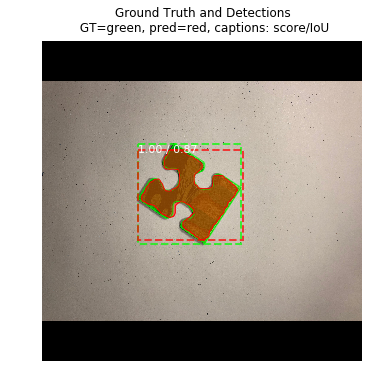

In [32]:
# display differences of ground truth mask & predicted mask for single image
res = display_differences(image_index=1) # pass in any index in the validation dataset (here, 0-20)

#### Apply `display_differences` on Validation Set

For a couple sections of this project, I'll be using an interactive widget from `ipywidgets`.  It is highly configurable and awesome, when used right.  In most of the following use cases, it will be so that (you) I can see and show what is currently going on, and change which image we're working with.  Instead of just choosing a single image as an example, I've chosen to create a dropdown that lets you select the image, which then re-runs the cell.

In [33]:
# allows for interactive cell, dropdown for changing values
!pip install ipywidgets
from ipywidgets import interact

In [0]:
validation_iou_results = [] # array to hold IoU results if switching between validation images

### @interact - Visualizing Individual Differences

In [35]:
@interact

def display_differences_on_validation(image_index=val_images_index):
  res = display_differences(image_index=image_index)
  validation_iou_results.append(res)
  
  for m in validation_iou_results:
    print(m)
  
  iou_masks = [d['iou_mask'] for d in validation_iou_results]
  iou_boxes = [d['iou_box'] for d in validation_iou_results]
  print("Running Avg Mask IoU: {}".format(np.mean(iou_masks)))
  print("Running Avg Box IoU: {}".format(np.mean(iou_boxes)))

interactive(children=(Dropdown(description='image_index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

## Model Accuracy/Loss Review - Intersect over Union (IoU)

***Intersect over Union (IoU)*** is an accuracy metric sometimes used in evaluating image segmentation models.  It measures the percent overlap between the ground truth mask and the predicted mask (or ground truth bounding box and predicted bounding box).  

The Intersection (target n prediction) is all the pixels of the prediction mask that are also in the ground truth mask, and the Union (target U prediction) is all the pixels covered by both the prediction and ground truth masks.

IoU, therefore, is: 

All of the overlapping pixels / All the pixels covered by both masks.

In [0]:
validation_ious = {"iou_mask": [], "iou_box": []}
for image_id in dataset_val.image_ids:
  ious = compute_ious(image_index=image_id)
  validation_ious['iou_mask'].append(ious['iou_mask'])
  validation_ious['iou_box'].append(ious['iou_box'])
  
validation_ious

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
 IoU (Mask): 0.790732204914093
 IoU (Box): 0.8343919261193158
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
 IoU (Mask): 0.8673806190490723
 IoU (Box): 0.8915595304639463
Processing 1 images
image                    shape: (1024, 1024, 3)       m

{'iou_box': [0.8343919261193158,
  0.8915595304639463,
  0.8859934281045178,
  0.9417968492518621,
  0.871283689913865,
  0.8982243500393916,
  0.7119980530542711,
  0.8749266862170088,
  0.8774047101106592,
  0.8099340502643931,
  0.8627331599047988,
  0.8791435625531226,
  0.765524625267666,
  0.8268104611233751,
  0.8910253533767107,
  0.9472288353120905,
  0.8200844430009744,
  0.9376565204112797,
  0.8584004798884584,
  0.9059980216420371,
  0.8911162790697674,
  0.9616047226070719],
 'iou_mask': [0.7907322,
  0.8673806,
  0.8369681,
  0.8901197,
  0.854295,
  0.8437252,
  0.58250576,
  0.8049956,
  0.8952851,
  0.8687637,
  0.89071286,
  0.82901967,
  0.86254466,
  0.74418813,
  0.8443852,
  0.8683157,
  0.7904455,
  0.8423928,
  0.85285133,
  0.8819683,
  0.8715252,
  0.8655973]}

#### Save IoU Results

In [0]:
IOU_RESULTS_FILENAME = ROOT_PROJECT_DIR / "results/iou_results.csv"

iou_df = pd.DataFrame.from_dict(validation_ious)
iou_df.to_csv(IOU_RESULTS_FILENAME, index=False)
iou_df.describe()

,iou_mask,iou_box
count,22.000000,22.000000
mean,0.835396,0.870220
std,0.067648,0.059061
min,0.582506,0.711998
25%,0.831007,0.840394
50%,0.853573,0.878274
75%,0.868652,0.896558
max,0.895285,0.961605


### IoU Recap

Given that (A) this is a single-class and single-instance image segmentation model, and that (B) the validation and test images are uncomplicated by background noise, the model should rarely, if ever, have false positives or false negatives.  And, though the images are generally "uncomplicated", the business application expects that someone (a puzzler) would follow the assumptions (taking photo in hand, in box, or on paper) made in the training.

Of the several model configurations ran, the best 10 and 20-epoch ones had the following results:

***The 10-epoch model's averages***:


*   Mask IoU: 84.46%
*   Box IoU: 83.30%

***The 20-epoch model's averages***:

*   Mask IoU: 83.54%
*   Box IoU: 87.02%


While it would be nice for the Mask IoUs to be higher, when inspecting the mask comparisons (above), they look pretty good, overall, and we should be able to extract enough of the puzzle piece.  Additionally, two of the validation images had poor box/mask scores (58% mask, 71% box; 74% mask, 82% box), which drove down the average a bit (given n = 22).  Looking at the image in question, it looks as if it is because a part of the puzzle piece is a turtle, while the majority is a water scene, and the model did not consider the turtle as part of the piece.




## Model Choices Recap

In the final model used, a couple of the configuration/design choices included:

*   **Pretrained Weights**: COCO
*   **Epochs**: 20
*   **DETECTION_MAX_INSTANCES**: 1 (expecting only 1 puzzle piece per image)
*   **MINI_MASK_SHAPE**: (224, 224)
*   **USE_MINI_MASK**: True
*   **DETECTION_MIN_CONFIDENCE**: 0.90
*   **STEPS_PER_EPOCH**: 100
*   **VALIDATION_STEPS**: 50
*   **LOSS_WEIGHTS**: {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.05,  'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}

And, in "inferior" models, a couple of the configuration/design choices included:

*   **Epochs**: 5, 10, 15
*   **USE_MINI_MASK**: False (caused RAM overload - was hoping to increase mask accuracy by avoiding minimization)
*   **MINI_MASK_SHAPE**: (28,28), (56,56) - searching for better mask IoUs
*   **LOSS_WEIGHTS**:  Increase/Decrease of mrcnn_mask_loss (vs others), and mrcnn_bbox_loss/class_loss
*   **DETECTION_MAX_INSTANCES**: 10 - originally, had annotated images of multiple pieces, but removed to increase single-piece mask IoU

# Part IV: Model Usage & Extract ROI/Mask

The model input/output flow:

1)  Receive image as input

2)  Predict instance classification (piece or background), bounding box, and mask

3)  Return new image, pixels (WxH) of the ROI (region of interest), with pixels of matched 

#### Set Path for Test Images

In [38]:

test_images_path = DATASET_PATH / "test/box_2/pieces"

test_images_paths = []
for img_path in os.listdir(test_images_path):
  test_images_paths.append(str(test_images_path / img_path))

test_images_paths

['/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9554.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9556.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9560.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9564.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9566.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9568.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9574.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9578.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_9579.jpeg',
 '/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_2/pieces/IMG_95

In [0]:
def image_filename_from_path_string(image_path_string):
  # split at last / and remove filetype (.jpeg)
  image_filename = image_path_string.rsplit('/', 1)[1].rsplit('.', 1)[0]
  return image_filename

In [0]:
def display_image(image, cmap='gray'):
  """
  Plot image from filepath
  image: image_file_path
  """
  image = plt.imread(image)
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  ax.imshow(image, cmap=cmap)
  plt.show()

### Instantiate Model (Inference Mode)

In [41]:
model_inference = MaskRCNN(
  mode='inference',
  model_dir=MODEL_DIR,
  config=PieceDetectorConfig()
  )

model_inference.load_weights(
  str(TRAINED_MODEL_PATH),
  by_name=True
  )

Re-starting from epoch 20


## PuzzlePieceLocator Class

1. Receive Image Input (path or array)
2. Run Model (Inference)
3. Find ROI (region of interest), draw bounding box, create mask
4. Convert Image to RGBA, and apply transparency (alpha channel) on pixels not marked as a puzzle piece
5. Create new image (new width, height) of only the ROI

In [0]:
class_names = ['BG', 'piece']

In [0]:
import datetime
from matplotlib import patches, lines

class PuzzlePieceLocator:
  """
  Class wrapper for running model on image (bounding box and image mask prediction).
  Takes ROI (bounding box) pixel coordinates from model.detect() and creates new image of only that location
  Takes Mask pixel coordinates from model.detect() and converts predicted background pixels to black, and adds alpha channel, making those pixels transparent
  Displays (part of) the image changes while running.
  """
  
  import datetime
  
  
  class_names = ['BG', 'piece']
    
  def __init__(self, image_path=None, image=None, i=0):
    '''
    expects input_path as only necessary parameter
    if no input_path, defaulting to the first image path in test array above
    
    ATTRS:
    final_iamge: the final, clipped ROI image with background masked
    results: results returned by model.detect()
    rois: (x,y) coordinates for result; single instance so only one is returned
    mask: mask of predicted piece; single instance so only one is returned 
    '''
    if image_path == None: # default to an image we've already loaded
      self.image_path = test_images_paths[i] 
      self.set_image(test_images_paths[i])
      self.final_image = None
      self.results = None
      self.rois = None
      self.mask = None
    else:
      self.image_path=image_path
      self.set_image(image_path)
      self.final_image = None
      self.results = None
      self.rois = None
      self.mask = None
    
    
  def set_image(self, image_path):
    self.image_path = image_path
    bgr_image = cv2.imread(image_path) # load image OpenCV (BGR)
    rgb_image = bgr_image[:,:,::-1] # convert to RGB
    self.image = rgb_image
        
  def detect_image(self, display_image=True):
    """
    Run the image segmentation model created above
    Visualize the predicted piece, bounding box, and mask
    """
    results = model_inference.detect([self.image], verbose=1)
    self.results = results[0]
    self.rois = results[0]['rois']
    self.mask = results[0]['masks']
    if display_image == True:
      mrcnn.visualize.display_instances(
        self.image,
        self.results['rois'],
        self.results['masks'],
        self.results['class_ids'],
        self.class_names,
        self.results['scores'],
        figsize=(8,8)
      )
    
  def detect_image_and_apply_mask(self, display_image=True):
    """
    Wrapper function to combiine detection (locating image) & applying mask/creating new image
    """
    self.detect_image()
    masked_image = self.apply_mask_roi()
    if display_image == True:    
      self.display_images()
    return masked_image

  # COLORS IMAGE WHERE MASK CONTAINS OBJECT
  def apply_mask(self, image, mask, color=(55, 66, 250), alpha=0.5):
    '''
    not actually used. this was initially used for shading the actual mask
    this is the reverse of apply_mask_reverse
    '''
    
    # iterate through color channels
    for c in range(3):
      
      # change pixels of image (first 2 dimensions)
      image[:,:,c] = np.where(mask == 1,
                           image[:,:,c] * 
                           (1 - alpha) + alpha * color[c] * 255,
                           image[:,:,c])
    
    return image
    
  def display_images(self):
    """
    Displays image at different states of process
    1: Original Input Image
    2: Image With Bounding Box (after model detection)
    3: Image With Bounding Box & Instance Mask
    4: IMAGE (ROI ONLY) & Image Segmentation Mask
    5: (New) Image (ROI only) & Masked Background (black, transparent)
    """
    fig, axes = plt.subplots(nrows=1,ncols=5, sharex=False, sharey=False, figsize=(16,16))
    ax1, ax2, ax3, ax4, ax5 = axes[0], axes[1], axes[2], axes[3], axes[4]
    
    ## FIVE IMAGES: ORIGINAL, BOUNDING BOX, MASKED, MASKED&ROI
    original_image = self.image # INPUT IMAGE
    mask = self.mask[:,:,0]
    masked_image = self.apply_mask(original_image.copy(), mask, alpha=0.8) # INPUT IMAGE WITH MASK
    
    rois = self.rois[0]
    roiy1, roix1, roiy2, roix2 = rois # ROIS (x,y) OF OBJECT DETECTED IN IMAGE
    p = patches.Rectangle((roix1, roiy1), roix2 - roix1, roiy2 - roiy1, linewidth=2, linestyle='dashed', edgecolor='red', facecolor='none')
    p2 = patches.Rectangle((roix1, roiy1), roix2 - roix1, roiy2 - roiy1, linewidth=2, linestyle='dashed', edgecolor='red', facecolor='none')
    
    roi_image = self.image_roi(original_image) # only image pixels inside bounding box
    final_image = self.final_image # roi image, with masked background
    masked_and_roi = self.image_roi(masked_image) # roi & mask
    
    # FIRST: ORIGINAL INPUT IMAGE
    ax1.imshow(original_image)
    ax1.set_xlabel("INPUT IMAGE", fontsize=14)
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax1.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
    
    # SECOND: IMAGE WITH BOUNDING BOX
    ax2.add_patch(p)
    ax2.imshow(original_image)
    ax2.set_xlabel("BBOX", fontsize=14)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
    
    # THIRD: IMAGE WITH BOUNDING BOX & INSTANCE MASK
    ax3.add_patch(p2)
    ax3.imshow(masked_image)
    ax3.set_xlabel("BBOX & MASK", fontsize=14)
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    ax3.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
    
    # FOURTH: IMAGE ROI & MASK
    ax4.imshow(masked_and_roi)
    ax4.set_xlabel("ROI & MASK", fontsize=14)
    ax4.set_yticklabels([])
    ax4.set_xticklabels([])
    ax4.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
    
    # FIFTH: IMAGE ROI (OBJECT LOCATION) & MASKED BACKGROUND
    ax5.imshow(final_image)
    ax5.set_xlabel("ROI & MASKED BKGRND", fontsize=14)
    ax5.set_yticklabels([])
    ax5.set_xticklabels([])
    ax5.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
        
    plt.show()
    
      
  # COLORS IMAGE WHERE MASK DOES NOT CONTAIN OBJECT
  def apply_mask_reverse_a(self, image, mask, color=(0,0,0), alpha=1):
    # iterate through color channels
    for c in range(3):
      # change pixels not in mask to black
      image[:,:,c] = np.where(mask == 1,
                           image[:,:,c],
                           0)
      # adding alpha, so background is transparent
      image[:,:,3] = np.where(mask==1,
                            255,
                            0
                           )
    return image
  
  # CONVERT IMAGE FROM RGB TO RGBA
  def image_with_alpha(self):
    """
    Adds alpha channel to piece image
    """
    image_alpha = self.image.copy()
    image_alpha = np.dstack(
        (image_alpha, np.full(
            (image_alpha.shape[0], image_alpha.shape[1]), 255, dtype=np.uint8
        )
       )
    )
    return image_alpha
  
  def apply_mask_roi(self):
    """
    Wrapper function for both applying mask and reducing image to only the ROI
    """
    image_alpha = self.image_with_alpha()
    masked_image = self.mask_background(image_alpha)
    masked_roi_image = self.image_roi(masked_image)
    self.final_image = masked_roi_image
    
    return masked_roi_image
    
  
  def image_roi(self, image):
    """
    Takes image (copy) as input, and ROI coordinates from model detection
    """
    rois = self.rois[0]
    # add padding to ROI so that mask is not on edge
    roix1, roiy1, roix2, roiy2 = rois[0] - 10, rois[2] + 10, rois[1] - 10, rois[3] + 10
    final_image = image[roix1:roiy1, roix2:roiy2]
    return final_image
  
  def mask_background(self, image_alpha):
    masked_image = image_alpha.astype(np.uint32).copy()
    mask = self.mask[:,:,0]
    masked_image = self.apply_mask_reverse_a(masked_image, mask)
#     masked_image_plot = masked_image.astype(np.uint8)
    
    self.final_image = masked_image
    
    return masked_image  

## PuzzlePieceLocator Usage

**Input**: Original Image Path (of the puzzle piece)

**Output**: New Image, WxH is the size of the ROI, and a masked (transparent) background where the model predicted background.

``puzzle_locater = PuzzlePieceLocater(image_path='/path/to/img.jpeg')``

``puzzle_locator.detect_image()`` 

 - runs trained model on image input, tries to locate, classify, and isolate puzzle piece

``new_image = puzzle_locator.apply_mask_roi(save_image=False)``

 - after detecting image, this will apply the transparent mask to what has been predicted as the background, and return a new image, with only the region of interest (which should contain the puzzle piece)


In [45]:
test_image_indices = list(range(len(test_images_paths)))
test_image_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [48]:
@interact

def detect_and_apply_mask(index=test_image_indices):
  '''
  runs model.detect() on selected test image index
  plots out stages of image: input, bounding box, box/mask, roi/mask, final image
  '''
  p = PuzzlePieceLocator(i=index)

  img = p.detect_image_and_apply_mask()

interactive(children=(Dropdown(description='index', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0), Outp…

Processing 1 images
image                    shape: (4032, 3024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


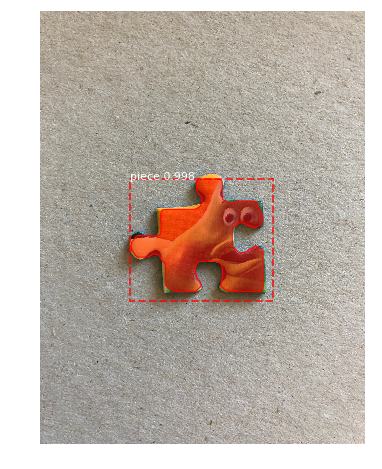

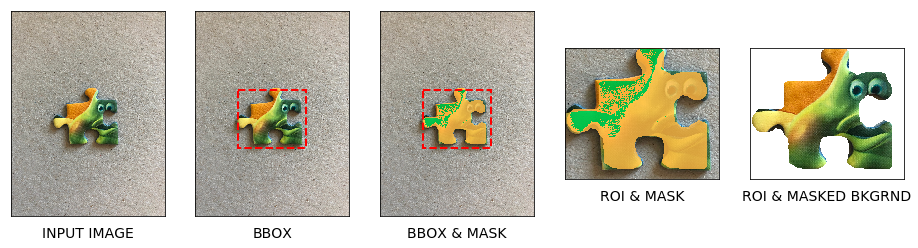

In [49]:
# same thing, but not interactive, so we can access this example later...
p = PuzzlePieceLocator(i=6)
img = p.detect_image_and_apply_mask()

With this `masked_image` of (hopefully) only the puzzle piece and transparent background, and a `box_image` that is a photo of the puzzle's box, we can now try to detect features of the puzzle piece in the box

## Application on Test Pieces - ROI Piece Extraction

In [0]:
def display_image_array(img, cmap='gray'):
  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  ax.imshow(img, cmap='gray')
    
def bgr_to_rgb_image(bgr_image):
  '''swap BGR (which open CV uses) to BGR, without '''
  rgb_image = bgr_image[:,:,::-1]
  return rgb_image

def display_image_and_box(image, box):
  '''
  display *loaded* image and box images, not paths
  '''
  fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=True, figsize=(12,8))
  ax1, ax2 = axes[0], axes[1]
  ax1.imshow(image)
  ax1.set_xlabel("Piece")
  ax2.imshow(box)
  ax2.set_xlabel("Box")

### Setting Box Image Paths

In [54]:
### BOX_1 => princesses
### BOX_2 => pixar comp
### BOX_3 => little mermaid
### BOX_4 => pixar draw
### BOX_5 => beauty & beast

# root of test images (broken down by box folders)
ROOT_TEST_PATH = DATASET_PATH / "test"

# where to save clipped pieces, in results/clipped_pieces/{box_#}
CLIPPED_PIECES_PARENT_PATH = ROOT_PROJECT_DIR / "results/clipped_pieces"

BOX_1_PATH = ROOT_TEST_PATH / "box_1/box.jpg"
BOX_2_PATH = ROOT_TEST_PATH / "box_2/box.jpg"
BOX_3_PATH = ROOT_TEST_PATH / "box_3/box.jpg"
BOX_4_PATH = ROOT_TEST_PATH / "box_4/box.jpg"
BOX_5_PATH = ROOT_TEST_PATH / "box_5/box.jpg"

print(BOX_1_PATH)

# ORIGINAL IMG PATHS
BOX_1_IMGS_PATH = ROOT_TEST_PATH / "box_1/pieces"
BOX_2_IMGS_PATH = ROOT_TEST_PATH / "box_2/pieces"
BOX_3_IMGS_PATH = ROOT_TEST_PATH / "box_3/pieces"
BOX_4_IMGS_PATH = ROOT_TEST_PATH / "box_4/pieces"
BOX_5_IMGS_PATH = ROOT_TEST_PATH / "box_5/pieces"

# CLIP IMG PATHS (created below, where we'll save clipped pieces)
BOX_1_CLIP_IMGS_PATH = CLIPPED_PIECES_PARENT_PATH / "box_1"
BOX_2_CLIP_IMGS_PATH = CLIPPED_PIECES_PARENT_PATH / "box_2"
BOX_3_CLIP_IMGS_PATH = CLIPPED_PIECES_PARENT_PATH / "box_3"
BOX_4_CLIP_IMGS_PATH = CLIPPED_PIECES_PARENT_PATH / "box_4"
BOX_5_CLIP_IMGS_PATH = CLIPPED_PIECES_PARENT_PATH / "box_5"

## LOADED IMAGES
box_1 = cv2.imread(str(BOX_1_PATH)) # BGR
box_2 = cv2.imread(str(BOX_2_PATH)) # BGR
box_3 = cv2.imread(str(BOX_3_PATH)) # BGR
box_4 = cv2.imread(str(BOX_4_PATH)) # BGR
box_5 = cv2.imread(str(BOX_5_PATH)) # BGR

box_1_rgb = bgr_to_rgb_image(box_1) # RGB
box_2_rgb = bgr_to_rgb_image(box_2) # RGB
box_3_rgb = bgr_to_rgb_image(box_3) # RGB
box_4_rgb = bgr_to_rgb_image(box_4) # RGB
box_5_rgb = bgr_to_rgb_image(box_5) # RGB

/content/gdrive/My Drive/2019_06_Puzzle/Mask_RCNN/dataset/images/test/box_1/box.jpg


### Display Boxes

In [55]:
box_titles = ["box_1", "box_2", "box_3", "box_4", "box_5"]
box_images = {
    "box_1": { "rgb": box_1_rgb, "bgr": box_1 }, 
    "box_2": { "rgb": box_2_rgb, "bgr": box_2 }, 
    "box_3": { "rgb": box_3_rgb, "bgr": box_3 }, 
    "box_4": { "rgb": box_4_rgb, "bgr": box_4 }, 
    "box_5": { "rgb": box_5_rgb, "bgr": box_5 }, 
}

@interact

def display_box(box=box_titles):
  box_rgb = box_images[box]["rgb"]
  box_bgr = box_images[box]["bgr"] # why not, to at least remember that OpenCV reads in as BGR, and not mix it up later.
  fig, axes = plt.subplots(nrows=1,ncols=2, sharex=False, sharey=False, figsize=(12,8))
  ax1, ax2 = axes[0], axes[1]
  ax1.imshow(box_bgr)
  ax1.set_xlabel("BGR")
  ax2.imshow(box_rgb)
  ax2.set_xlabel("RGB")

interactive(children=(Dropdown(description='box', options=('box_1', 'box_2', 'box_3', 'box_4', 'box_5'), value…

### Iterate Over Test Boxes/Pieces & Clip Images

Inside the dataset/images/test folder, I have a folder for each box, which contains:

*   Box Image (*box.jpeg*)
*   Folder (*/pieces*) that contains images of pieces for that box

For each box, I will be:

1.  Iterating over the images in the pieces folder
2.  Passing each image through the model and extracting the ROI and masking the background
3.  Saving new image in a results folder (*ROOT_PROJECT_DIR/results/clipped_pieces/box_#*)

This way, when later applying feature extraction, I already have the isolated images and I know which box they belong to.


In [0]:
PATHS_FOR_DETECTION = [
    {"pieces_dir": BOX_1_IMGS_PATH, "clip_dir": BOX_1_CLIP_IMGS_PATH },
    {"pieces_dir": BOX_2_IMGS_PATH, "clip_dir": BOX_2_CLIP_IMGS_PATH },
    {"pieces_dir": BOX_3_IMGS_PATH, "clip_dir": BOX_3_CLIP_IMGS_PATH },
    {"pieces_dir": BOX_4_IMGS_PATH, "clip_dir": BOX_4_CLIP_IMGS_PATH },
    {"pieces_dir": BOX_5_IMGS_PATH, "clip_dir": BOX_5_CLIP_IMGS_PATH }
]

# SET FILEPATH/NAME for new image
def set_clip_image_name(img_name, clip_dir):
  img_filename = img_name.rsplit('.', 1)[0] # removed .jpeg
  clip_img_filename = img_filename + "_clip" + ".jpeg"
  clip_img_filepath = str(clip_dir / clip_img_filename)
  return clip_img_filepath

# CONVERT image and save
def save_clip_image(clip_img_filepath, clip_img):
  clip_img = clip_img.astype(np.uint8).copy()
  clip_img = cv2.cvtColor(clip_img, cv2.COLOR_BGRA2RGBA)
  cv2.imwrite(clip_img_filepath, clip_img)
  

def clip_and_save_images_from_box(pieces_dir, clip_dir):
  
  for img_name in os.listdir(pieces_dir):
    
    # set new image filepath
    clip_img_filepath = set_clip_image_name(img_name, clip_dir)
    
    # detect piece
    p = PuzzlePieceLocator(image_path=str(pieces_dir / img_name))
    clip_img = p.detect_image_and_apply_mask(display_image=False)
    
    # save new image
    save_clip_image(clip_img_filepath, clip_img)

In [0]:
# iterate over box paths, using methods above
for p in PATHS_FOR_DETECTION:
  pieces_dir = p['pieces_dir']
  clip_dir = p['clip_dir']
  clip_and_save_images_from_box(pieces_dir, clip_dir)

Processing 1 images
image                    shape: (4032, 3024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (4032, 3024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 4032.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (4032, 3024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.1

# Part V: Feature Matching 



### SIFT (Scale-Invarient Feature Transform)

To find one image inside another, there are a couple of different algorithms available, and for this experiment, the [SIFT](https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html) algorithm works best for a couple reasons:

1) We are ***not looking for an exact copy*** of image A (piece) inside image B (box)

2) The piece's ***rotation is unknown***, and we have to be able to look for features inside the puzzle piece at different orientations.

3) The piece, most likely, is not directly photographed - so the piece and its ***features may be slightly skewed***.  

4) The photo of the puzzle piece and box are ***not on the same scale***. The piece should be much smaller (1/100, or however many pieces are in the box), so we need to be able to feature match at different scales.

### Dictionaries To Keep Track of Feature Matching Process Time & Successfulness

Here, I'm creating empty dictionaries, with keys for each box, to monitor and save:

1. Elapsed Time - (`feature_matching_time_dict`) to see differences in feature matching speed across box sizes & complexity
2. Success - (`feature_matching_success_dict`) True/False, whether enough matches (10 keypoints) were found between the piece and its box

In [0]:
feature_matching_time_dict = {"box_1": [], "box_2": [], "box_3": [], "box_4": [], "box_5": []}
feature_matching_success_dict = {"box_1": [], "box_2": [], "box_3": [], "box_4": [], "box_5": []}

FEATURE_MATCHES_SAVE_PATH = ROOT_PROJECT_DIR / "results/feature_matches"

## SIFT DETECTOR

In [0]:
from timeit import default_timer as timer
from skimage import measure
import datetime

class PuzzlePieceDetector():

  def __init__(self, image_piece, image_box, box_name, display_on_init=False):
    self.image_piece = image_piece
    self.image_box = image_box
    self.box_name = box_name

    image_as8 = image_piece.astype(np.uint8).copy()
    ##
    ## IMAGE CREATED VIA FIRST PART IS RGBA
    ##

    self.gray_image_piece = cv2.cvtColor(image_as8, cv2.COLOR_RGBA2GRAY)


    ##
    ## BOX IMAGE IMPORTED USING cv2.imread() so is BGRA
    ##
    self.rgb_image_box = cv2.cvtColor(image_box, cv2.COLOR_BGR2RGB)
    self.gray_image_box = cv2.cvtColor(image_box, cv2.COLOR_BGR2GRAY)

    if display_on_init == True:
      self.display_images()

  def display_images(self):
    '''
    used in development, but not necessarily needed at the end
    useful if you are running the process in a different manner
    and want to see the piece and box you are matching, before actually trying to match
    '''
    fig, axes = plt.subplots(nrows=2,ncols=2, sharex=False, sharey=False, figsize=(16,16))
    axes_list = [item for sublist in axes for item in sublist]
    images = [self.image_piece, self.gray_image_piece, self.rgb_image_box, self.gray_image_box]
    for i in images:
      ax = axes_list.pop(0)
      ax.imshow(i, cmap='gray')


  def display_image(self, img, cmap='gray'):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')


  def bgr_to_rgb(self, img):
    '''
    convert image in BGR (OpenCV) to RGB
    '''
    rgb_img = img[:,:,::-1]
    return rgb_img


  def visualize_piece_location(self):

    start = timer()
    
    '''
    get keypint and descriptors in OpenCV using SIFT
    '''
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(self.gray_image_piece, None)
    kp2, des2 = sift.detectAndCompute(self.gray_image_box, None)

    FLANN_INDEX_KDTREE = 0
    MIN_MATCH_COUNT = 10
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test
    good = []
    for m,n in matches:
      if m.distance < 0.7*n.distance:
        good.append(m)

    if len(good)>MIN_MATCH_COUNT:
      # ENOUGH FEATURES DETECTED => add to successful dict
      feature_matching_success_dict[self.box_name].append(True)
      
      src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
      matchesMask = mask.ravel().tolist()
      
      
      ## POLYGON POINTS FOR TRANSFORMED BOUNDING BOX
      h,w = self.gray_image_piece.shape
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
      dst = cv2.perspectiveTransform(pts,M)
      
      
      ## POLYGON POINTS OF PIECE
      contours = measure.find_contours(self.gray_image_piece[:], 0.5)
      
      # flip (y, x) to (x, y)
      vert_index = 0
      for verts in contours:
        verts = np.fliplr(verts)
        contours[vert_index] = verts
        vert_index += 1
      
      # RESHAPE INTO (x, 1, 2)
      pts2 = np.float32([ contours[0]]).reshape(-1,1,2)
      
      # TRANSFORM polygon points perspective in destination image
      dst2 = cv2.perspectiveTransform(pts2,M)
      
      # DRAW transformed polygon of image piece on box
      self.gray_image_box = cv2.polylines(self.gray_image_box,[np.int32(dst2)],True,255,5, cv2.LINE_AA)

    else:
      print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
      # NOT ENOUGH FEATURES DETECTED => add to successful dict
      feature_matching_success_dict[self.box_name].append(False)
      matchesMask = None


    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    
    # Polygon points of original piece
    contours = measure.find_contours(self.gray_image_piece[:], 0.5)

    # DRAW polygon points of piece around piece image
    fig, ax = plt.subplots(figsize=(20,20))
    for n, contour in enumerate(contours):
      ax.plot(contour[:, 1], contour[:, 0], linewidth=3)

    # DRAW final image, with piece on left side, box on right side
    img3 = cv2.drawMatches(self.gray_image_piece,kp1,self.gray_image_box,kp2,good,None,**draw_params)
    plt.imshow(img3)
    
    
    ### UNCOMMENT IF YOU WANT TO SAVE IMAGE MATCHES
#     filename = "match_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
#     save_image_path = str(FEATURE_MATCHES_SAVE_PATH / self.box_name / filename)
#     plt.savefig(save_image_path)
#     plt.close(fig)
    
    
    plt.show()
    
    end = timer()
    time_elapsed = end-start
    print("Time in seconds: {}".format(end-start))
    feature_matching_time_dict[self.box_name].append(time_elapsed)
    return time_elapsed

## Feature Matching (Single Image)

#### Preview Test Box

When playing around with the feature matching, the following cell is the **key** cell for switching boxes.  To switch boxes and pieces, just swap out the `_#` after the box variables, and re-run. (i.e. `box_5` > `box_1`)

In [0]:
PREVIEW_IMAGES_PATH = BOX_5_CLIP_IMGS_PATH
PREVIEW_IMAGES_BOX = box_5
PREVIEW_IMAGES_BOX_NAME = 'box_5' # for saving in dictionary tracking time/success

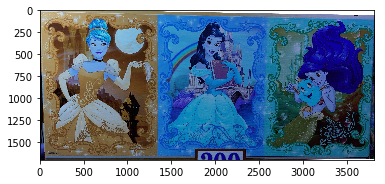

In [0]:
display_image_array(PREVIEW_IMAGES_BOX)

#### Preview Clipped Images

The next interactive cell is for previewing an image for the box set above.  Can be skipped, but useful if you want to switch between boxes, and check pieces to find a piece of interest.

In [60]:
@interact

def preview_image_for_matching(img_paths=os.listdir(PREVIEW_IMAGES_PATH)):
  display_image(str(PREVIEW_IMAGES_PATH / img_paths))

interactive(children=(Dropdown(description='img_paths', options=('IMG_9653_clip.jpeg', 'IMG_9652_clip.jpeg', '…

### Interactive Feature Matching

The next interactive cell is for choosing a piece and then running feature matching between it and its box.  The `run_it` is set to `False` so that you can preview an image without automatically running feature matching on it, which can take a varying amount of time depending on box size and complexity.

When wanting to run feature matching on the selected piece, set `run_it` to `True`.  After, to save time, toggle `run_it` to `False`, and use the dropdown to preview another image.  When you've found an image you are interested in feature matching, toggle back `run_it` to `True`.

In [63]:
@interact

def feature_match_image(img_paths=os.listdir(PREVIEW_IMAGES_PATH), run_it=[False, True]):
  if run_it == True:
    full_image_path = str(PREVIEW_IMAGES_PATH / img_paths)
    image_piece = bgr_to_rgb_image(cv2.imread(full_image_path))
    pp_detector = PuzzlePieceDetector(image_piece=image_piece, image_box = PREVIEW_IMAGES_BOX, box_name=PREVIEW_IMAGES_BOX_NAME, display_on_init=False)
    pp_detector.visualize_piece_location()
  else:
    full_image_path = str(PREVIEW_IMAGES_PATH / img_paths)
    img = bgr_to_rgb_image(cv2.imread(full_image_path))
    rgb_box = bgr_to_rgb_image(PREVIEW_IMAGES_BOX)
    display_image_and_box(img, rgb_box)

interactive(children=(Dropdown(description='img_paths', options=('IMG_9653_clip.jpeg', 'IMG_9652_clip.jpeg', '…

## Feature Matching Recap

For the five tested boxes:

Average Feature Match Processing Time (s):

*   Box 1 - Princesses - ***22 seconds***, outliers as high as 120s, but most ~ 16s
*   Box 2 - Pixar Compilation - ***40 seconds***, outliers as high as 120s, but most ~ 35s
*   Box 4 - Pixar Drawing - ***35 seconds***, outliers as high as 70s
*   Box 5 - Beauty & Beast - ***29 seconds***, longest 37s

The complexity of the puzzle, in general, resulted in different processing times for feature matching, with the more complicated puzzles (Pixar Compilation, Pixar Drawing) taking significantly longer.  Unsurprisingly, the feature matching was also more successful on the 'easier' puzzles, with the success rate for Box 1/Box 5 being 70% or greater and the success rate for Box 2/Box 4 under 50%.  That being said, a "success" was considered being able to place the piece in the puzzle - and sometimes, during failed feature matching, the algorithm still found a couple features in the true location of the puzzle piece, just not enough to accurately place it.  However, there are still ways to tweak the feature matching aspect to possible save time and improve accuracy.



In [0]:
# feature_matching_time_dict
fm_time = pd.DataFrame.from_dict(feature_matching_time_dict['box_5'])
fm_time.describe()

,0
count,5.000000
mean,29.607079
std,8.311351
min,17.027276
25%,27.822400
50%,28.884675
75%,36.626711
max,37.674332


# Part VI: Visualization of Results

### Intersect over Union Visualization on Validation Set
![IoU](https://i.imgur.com/Of4j8bV.png)

### Visualization of Image Segmentation/ROI/Mask Process
![images](https://i.imgur.com/4aBecLk.gif)

### Clipped Pieces
<img src="https://i.imgur.com/mEJa0wi.png" alt="piece1" width="200"/>
<img src="https://i.imgur.com/TvrTxI2.png" alt="piece2" width="200"/>
<img src="https://i.imgur.com/RxRufU3.png" alt="piece3" width="200"/>

### Successful Feature Matches
![feature matches](https://i.imgur.com/Ge0k4gX.gif)



# Part VII: Final Notes

## Areas of Improvement

* Sometimes, when applying the perspective transformation on the puzzle piece's contours, **the piece's outline can be distorted** into several lines across the image.  This is something that should be fixable, given a little more time.

* Applying **a second feature matching algorithm** if the first fails to detect a match, or applying SIFT again with a new set of parameters.

* While SIFT is scale invarient, one way to improve the feature matching would be to, if possible, **adjust its invariance to scale**.  That is, a puzzle piece can only be 1/100, 1/200, 1/500, 1/1000 the size of the box image (depending on the number of pieces in the puzzle).  If I could provide SIFT with the knowledge that it does not have to consider scales in which the puzzle piece could not exist, the algorithm should, at the very least, have a faster performance.  Additionally, being cognizant of maximum scale for the piece image, it might also extract more/better features.

* Passing in **multiple images of the same piece** into the feature matching algorithm might also result in a greater percent of successful matches, but this also requires taking more photos.

## Alternative Image Segmentation Model & Process

While the final model had a respectable Mask IoU of ~84% and Box Iou of ~87%, I believe that this could break the 90% threshold by:


1. Requiring a photo of the backside of the puzzle piece (in addition to the front side and box)
2. Instead of training the model on the front sides, train the model on the backs of puzzle pieces
3. Pass in backside of puzzle piece into model when doing image segmentation (inference mode)
4. Horizontal flip the extracted ROI of the backside, so that it's flipped shape matches the outlines of the front side
5. Apply SIFT feature detection between the flipped, backside and the frontside piece, isolating the frontside.
6. Extract match from SIFT detection and create instance segmentation mask on the frontside image.
7. Take this final mask and apply SIFT feature detection between this and the box image.

Given that puzzle pieces have a significant amount of internal edges and features that may distract or mislead an image segmentation model (sometimes, for example, when an object was only partially contained in the piece, the model did not include this part in its prediction of the piece), training on the backside, and then horizontally flipping the extracted mask should result in a higher intersect over union for both the mask and box predictions.

That being said, I do not believe that the model's accuracy of image segmentation held back the final performance of the model as much as the feature matching aspect did.  


## Future Work

*   If I can find a way to speed up the feature detection, hosting the final result online, with the test images and boxes so that it is interactive.  Additionally, allowing upload of new box images and puzzle pieces.

*   Fine tuning feature detection's scale invariance

## Headaches

*   First time working in google colab, so there was a learning curve in just figuring out file navigation, shortcuts, and how to properly install and reference parts of the project. Plus, a couple crashes during model training.

*  Not enough exposure to or intimate knowledge of `measure.find_contours`, and `cv2.perspectiveTransform` to handle cases when the transformed piece outline broke when drawing on the final image.  Time was spent here, but unsuccessfully.

*   Knowledge creep between classes and functions over the life of the project, and wanting to be able to access things like `box_image` or `box_name` in places where it should not necessarily live.  

# Resources

### Best

- [matterport - Splash of Color: Instance Segmentation with Mask R-CNN](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46)

- [github - Mask R_CNN](https://github.com/matterport/Mask_RCNN)

- [opencv-python - Feature Matching + Homography to Find Objects](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)

### Plotting / Utility

- [Long explanation of using plt subplots to create small multiples](http://jonathansoma.com/lede/data-studio/classes/small-multiples/long-explanation-of-using-plt-subplots-to-create-small-multiples/)

- [pythoncentral - How to Recursively Copy A Folder In Python](https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/)

- [towardsdatascience - Getting Started with TensorFlow in Google Colaboratory](https://towardsdatascience.com/getting-started-with-tensorflow-in-google-colaboratory-9a97458e1014)

- [docs.opencv - Drawing Functions](https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html)

- [scikit-image.org - Contour Finding](https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html)

- [docs.opencv - Contour Features](https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html)

- [stackoverflow - Python hide ticks but show tick labels](https://stackoverflow.com/questions/29988241/python-hide-ticks-but-show-tick-labels/29988431)

### Instance Segmentation / Mask RCNN

- [hackernoon - Object Detection in Google Colab with Custom Dataset](https://hackernoon.com/object-detection-in-google-colab-with-custom-dataset-5a7bb2b0e97e)

- [hackernoon - Instance Segmentation in Google Colab with Custom Dataset](https://hackernoon.com/instance-segmentation-in-google-colab-with-custom-dataset-b3099ac23f35)

- [towardsdatascience - Mask R-CNN for Ship Detection & Segmentation](https://towardsdatascience.com/mask-r-cnn-for-ship-detection-segmentation-a1108b5a083)

- [pyimagesearch - Mask R-CNN with OpenCV](https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/)

- [pyimagesearch - Mask R-CNN](https://www.pyimagesearch.com/2019/06/10/keras-mask-r-cnn/)

- [vidhya - Step-by-Step Introduction to Image Segmentation Techniques](https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/)

- [medium - Review of Deep Learning Algorithms](https://medium.com/@arthur_ouaknine/review-of-deep-learning-algorithms-for-image-semantic-segmentation-509a600f7b57)

- [jeremyjordan - An overview of semantic image segmentation](https://www.jeremyjordan.me/semantic-segmentation/)

- [github - Image Segmentation with tf.keras](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)

- [colab - maskrcnn_custom_tf_colab.ipynb](https://colab.research.google.com/github/RomRoc/maskrcnn_train_tensorflow_colab/blob/master/maskrcnn_custom_tf_colab.ipynb#scrollTo=X7iSzccTL9hM)

- [towardsdatascience - CNN Application - Detecting Car Exterior Damage](https://towardsdatascience.com/cnn-application-detecting-car-exterior-damage-full-implementable-code-1b205e3cb48c)


### Feature Matching

- [washington.edu - SIFT (pdf)](https://courses.cs.washington.edu/courses/cse576/11sp/notes/SIFT_white2011.pdf)

- [stackoverflow - How to get pixel coordinates from Feature Matching in OpenCV](https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python)

- [kaggle - From Masks to Rotating Bounding Boxes using OpenCV](https://www.kaggle.com/frappuccino/from-masks-to-rotating-bounding-boxes-using-opencv)

- [stackoverflow - how to straighten a rotated rectangle area of an image using opencv](https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python)

- [github - Including Non-Free Algorithms in OpenCV](https://github.com/skvark/opencv-python/issues/126)

- [opencv-python - Introduction to SIFT](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html)

- [opencv-python - Feature Matching + Homography to Find Objects](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)

- [docs.opencv - Brute Force & Flann Based Matcher](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html)

- [github.io - cv.findHomography docs](https://kyamagu.github.io/mexopencv/matlab/findHomography.html)

- [learnopencv - Image Alignment using OpenCV C++](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/)

- [opencv-python - Template Matching](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html)

- [washington.edu - Features & Image Matching - PDF](https://courses.cs.washington.edu/courses/cse455/09wi/Lects/lect6.pdf)



